In [1]:
import pandas as pd

In [2]:
df_ratio_cpu = pd.read_csv('NAB/data/realAWSCloudwatch/ec2_cpu_utilization_24ae8d.csv')

In [3]:
df_ratio_cpu.head()

,timestamp,value
0,2014-02-14 14:30:00,0.132
1,2014-02-14 14:35:00,0.134
2,2014-02-14 14:40:00,0.134
3,2014-02-14 14:45:00,0.134
4,2014-02-14 14:50:00,0.134


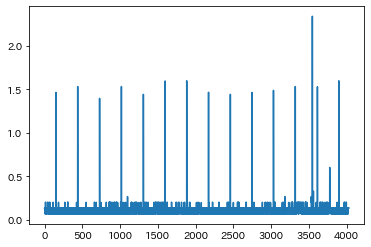

In [4]:
df_ratio_cpu['value'].plot()

In [5]:
df_ratio_cpu_2 = pd.read_csv('NAB/data/realAWSCloudwatch/ec2_cpu_utilization_53ea38.csv')

In [6]:
df_ratio_cpu_2.head()

,timestamp,value
0,2014-02-14 14:30:00,1.732
1,2014-02-14 14:35:00,1.732
2,2014-02-14 14:40:00,1.960
3,2014-02-14 14:45:00,1.732
4,2014-02-14 14:50:00,1.706


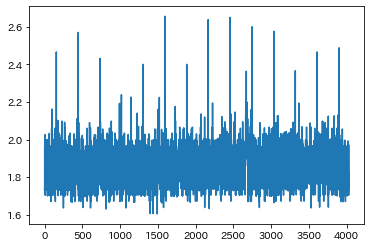

In [7]:
df_ratio_cpu_2['value'].plot()

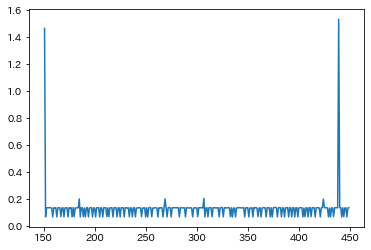

In [8]:
x = 300*1
df_ratio_cpu['value'][151:x+150].plot()

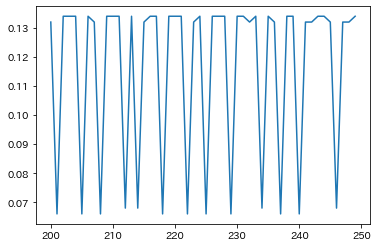

In [9]:
df_ratio_cpu['value'][200:250].plot()

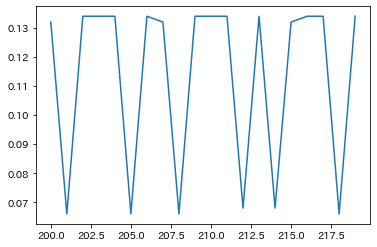

In [10]:
df_ratio_cpu['value'][200:220].plot()

In [11]:
import json

In [12]:
json_open = open('NAB/labels/combined_labels.json', 'r')
json_load = json.load(json_open)

In [13]:
list_anomaly_time = json_load['realAWSCloudwatch/ec2_cpu_utilization_24ae8d.csv']

In [14]:
df_ratio_cpu['label'] = [0] * len(df_ratio_cpu['value'])

In [15]:
for t in json_load['realAWSCloudwatch/ec2_cpu_utilization_24ae8d.csv']:
    df_ratio_cpu.loc[df_ratio_cpu['timestamp']==t, 'label'] = 1

In [16]:
for t in json_load['realAWSCloudwatch/ec2_cpu_utilization_24ae8d.csv']:
    print(df_ratio_cpu[df_ratio_cpu['timestamp']==t])

                timestamp  value  label
3547  2014-02-26 22:05:00  2.344      1
                timestamp  value  label
3777  2014-02-27 17:15:00  0.602      1


In [98]:
df_ratio_cpu[(df_ratio_cpu['value']>1.3) & (df_ratio_cpu['label'] != 1)]

,timestamp,value,label
151,2014-02-15 03:05:00,1.466,0
439,2014-02-16 03:05:00,1.534,0
729,2014-02-17 03:15:00,1.398,0
1018,2014-02-18 03:20:00,1.534,0
1309,2014-02-19 03:35:00,1.444,0
1597,2014-02-20 03:35:00,1.598,0
1883,2014-02-21 03:25:00,1.600,0
2172,2014-02-22 03:30:00,1.468,0
2461,2014-02-23 03:35:00,1.444,0
2748,2014-02-24 03:30:00,1.466,0


In [79]:
list_idx = []
for idx in df_ratio_cpu[(df_ratio_cpu['value']>1.3) & (df_ratio_cpu['label'] != 1)].index:
    list_idx.append(idx)

In [83]:
list_idx_interval = []
for i in range(len(list_idx)-1):
    list_idx_interval.append(list_idx[i+1] - list_idx[i])
    
list_idx_interval = np.array(list_idx_interval)

In [115]:
np.median(list_idx_interval)

289.0

In [18]:
import numpy as np

In [117]:
#トレーニングデータの作成
series_ratio_cpu_value = df_ratio_cpu['value']
window_size = 289 #10では偽陰性が100% 3だと偽陰性100%擬陽性も2件
tmp_x = []
tmp_y = []

for i in range(152, len(series_ratio_cpu_value) - window_size):
    tmp_x.append(series_ratio_cpu_value[i:i+window_size])
    
    if df_ratio_cpu['timestamp'][i+window_size] in list_anomaly_time:
        tmp_y.append(1)
    else:
        tmp_y.append(0)
    
train_X = np.array(tmp_x)
train_Y = np.array(tmp_y)

In [118]:
series_ratio_cpu_value.min()

0.066

In [102]:
#標準化：多変量の時に変数間の値に差があるときに使用
#train_X = (train_X - np.mean(train_X)) / np.std(train_X)

#正規化
#train_X /= np.nanmax(np.abs(train_X))

In [103]:
train_X

array([[0.066, 0.134, 0.134, ..., 0.066, 0.134, 0.068],
       [0.134, 0.134, 0.134, ..., 0.134, 0.068, 0.132],
       [0.134, 0.134, 0.134, ..., 0.068, 0.132, 0.134],
       ...,
       [0.134, 0.132, 0.132, ..., 0.132, 0.132, 0.134],
       [0.132, 0.132, 0.066, ..., 0.132, 0.134, 0.134],
       [0.132, 0.066, 0.134, ..., 0.134, 0.134, 0.134]])

In [104]:
train_Y

array([0, 0, 0, ..., 0, 0, 0])

### モデルの作成

In [105]:
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense, Activation, LSTM
from keras import optimizers
from keras.layers.recurrent import SimpleRNN
from keras.callbacks import EarlyStopping
import tensorflow_addons as tfa
import focal_loss
from sklearn.metrics import confusion_matrix
from keras.utils.np_utils import to_categorical

In [106]:
train_X = np.array(train_X).reshape(len(train_X), window_size, 1)
train_Y = np.array(train_Y).reshape(len(train_Y), 1)

In [107]:
train_X[0]

array([[0.066],
       [0.134],
       [0.134],
       [0.134],
       [0.134],
       [0.134],
       [0.132],
       [0.066],
       [0.134],
       [0.132],
       [0.134],
       [0.066],
       [0.134],
       [0.134],
       [0.134],
       [0.068],
       [0.132],
       [0.134],
       [0.066],
       [0.132],
       [0.134],
       [0.134],
       [0.066],
       [0.134],
       [0.132],
       [0.134],
       [0.066],
       [0.136],
       [0.068],
       [0.132],
       [0.132],
       [0.134],
       [0.134],
       [0.2  ],
       [0.066],
       [0.134],
       [0.134],
       [0.068],
       [0.132],
       [0.066],
       [0.132],
       [0.136],
       [0.066],
       [0.132],
       [0.134],
       [0.134],
       [0.066],
       [0.134],
       [0.132],
       [0.066],
       [0.134],
       [0.134],
       [0.134],
       [0.066],
       [0.134],
       [0.132],
       [0.066],
       [0.134],
       [0.134],
       [0.134],
       [0.068],
       [0.134],
       [

In [108]:
from sklearn.model_selection import StratifiedKFold

kfold = StratifiedKFold(n_splits=2, shuffle=True, random_state=0)

In [109]:
for train, val in kfold.split(train_X, train_Y):
    train_X_skf = train_X[train]
    train_Y_skf = train_Y[train]
    
    val_X_skf =  train_X[val]
    val_Y_skf =  train_Y[val]

In [110]:
val_Y_skf

array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]])

In [111]:
#sigmoid
def build_rnn_model(units):
    # モデルの構築
    rnn_model = Sequential()
    rnn_model.add(LSTM(units, input_shape=(None, 1), return_sequences=False, recurrent_activation='relu'))
    rnn_model.add(Dense(1, activation='sigmoid'))  #全結合層
    rnn_model.compile(loss= tfa.losses.focal_loss.SigmoidFocalCrossEntropy(), optimizer=optimizers.Adam(amsgrad=True), metrics=['accuracy'])
    #rnn_model.summary()

    return rnn_model

In [112]:
#input_shape = (len(train_Y), window_size, 1)
units = 300

model = build_rnn_model(units)

epochs = 100000
batch_size = len(train_Y_skf)#//10
early_stopping = EarlyStopping(monitor='val_loss', patience=1, verbose=0)

In [113]:
rnn_history = model.fit(train_X_skf, train_Y_skf,
                        batch_size=batch_size, 
                        epochs=epochs, 
                        callbacks=early_stopping,
                       #)
                       # validation_split=0.1)
                        validation_data=(val_X_skf, val_Y_skf))

Epoch 1/100000
1/1 [==============================] - 12s 12s/step - loss: 0.1299 - accuracy: 5.5741e-04 - val_loss: 0.1296 - val_accuracy: 0.9994
Epoch 2/100000
1/1 [==============================] - 10s 10s/step - loss: 0.1296 - accuracy: 0.9994 - val_loss: 0.1293 - val_accuracy: 0.9994
Epoch 3/100000
1/1 [==============================] - 10s 10s/step - loss: 0.1293 - accuracy: 0.9994 - val_loss: 0.1290 - val_accuracy: 0.9994
Epoch 4/100000
1/1 [==============================] - 9s 9s/step - loss: 0.1290 - accuracy: 0.9994 - val_loss: 0.1286 - val_accuracy: 0.9994
Epoch 5/100000
1/1 [==============================] - 10s 10s/step - loss: 0.1286 - accuracy: 0.9994 - val_loss: 0.1281 - val_accuracy: 0.9994
Epoch 6/100000
1/1 [==============================] - 9s 9s/step - loss: 0.1280 - accuracy: 0.9994 - val_loss: 0.1274 - val_accuracy: 0.9994
Epoch 7/100000
1/1 [==============================] - 9s 9s/step - loss: 0.1274 - accuracy: 0.9994 - val_loss: 0.1265 - val_accuracy: 0.9994
E

KeyboardInterrupt: 

In [68]:
len(rnn_history.history['loss']) - 1

21

In [69]:
preds = model.predict_classes(train_X, verbose=0)

In [70]:
cm = confusion_matrix(train_Y, preds)

In [71]:
cm

array([[3579,    0],
       [   2,    0]], dtype=int64)

In [174]:
cm.flatten()

array([3579,    0,    2,    0], dtype=int64)

In [34]:
#softmax
def build_rnn_model(units):
    # モデルの構築
    rnn_model = Sequential()
    rnn_model.add(SimpleRNN(units, input_shape=(None, 1), return_sequences=False, activation='relu'))
    rnn_model.add(Dense(2, activation='softmax'))  #全結合層
    rnn_model.compile(loss= focal_loss.SparseCategoricalFocalLoss(gamma=2.0), optimizer=optimizers.Adam(amsgrad=True), metrics=['accuracy'])
    #rnn_model.summary()

    return rnn_model

In [42]:
#input_shape = (len(train_Y), window_size, 1)
units = 300

model = build_rnn_model(units)

epochs = 100000
batch_size = len(train_Y_skf)#//10
early_stopping = EarlyStopping(monitor='val_loss', patience=1, verbose=0)

In [43]:
Y_train_cateforicaled

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [44]:
#Y_train_cateforicaled = to_categorical(train_Y_skf, num_classes=None)
#Y_val_cateforicaled = to_categorical(val_Y_skf, num_classes=None)

rnn_history = model.fit(train_X_skf, train_Y_skf,
                        batch_size=batch_size, 
                        epochs=epochs, 
                        callbacks=early_stopping,
                       #)
                       # validation_split=0.1)
                        validation_data=(val_X_skf, val_Y_skf))

Epoch 1/100000
1/1 [==============================] - 2s 2s/step - loss: 0.1763 - accuracy: 0.0028 - val_loss: 0.1676 - val_accuracy: 0.9966
Epoch 2/100000
1/1 [==============================] - 3s 3s/step - loss: 0.1676 - accuracy: 0.9944 - val_loss: 0.1585 - val_accuracy: 0.9966
Epoch 3/100000
1/1 [==============================] - 2s 2s/step - loss: 0.1586 - accuracy: 0.9950 - val_loss: 0.1439 - val_accuracy: 0.9989
Epoch 4/100000
1/1 [==============================] - 2s 2s/step - loss: 0.1439 - accuracy: 0.9994 - val_loss: 0.1172 - val_accuracy: 0.9994
Epoch 5/100000
1/1 [==============================] - 2s 2s/step - loss: 0.1171 - accuracy: 0.9994 - val_loss: 0.0426 - val_accuracy: 0.9994
Epoch 6/100000
1/1 [==============================] - 2s 2s/step - loss: 0.0425 - accuracy: 0.9994 - val_loss: 0.0090 - val_accuracy: 0.9994
Epoch 7/100000
1/1 [==============================] - 2s 2s/step - loss: 0.0090 - accuracy: 0.9994 - val_loss: 0.0090 - val_accuracy: 0.9994


In [45]:
len(rnn_history.history['loss']) - 1

6

In [46]:
preds = model.predict_classes(train_X, verbose=0)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [47]:
preds

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [48]:
cm = confusion_matrix(train_Y, preds)

In [49]:
cm

array([[3579,    0],
       [   2,    0]], dtype=int64)

In [174]:
cm.flatten()

array([3579,    0,    2,    0], dtype=int64)